# Workflow for using the profiler (in python).

In [1]:
# imports
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import cycle
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
pd.set_option('max_rows',1000)
import os
import math
from matplotlib.backends.backend_pdf import PdfPages
import scipy
from scipy import stats
import subprocess

prefix = "/Volumes/users/Corinne_Simonti/projects/RNA/"

### RNAstructure
#### In order to use the profiler, you must use sampling from RNAstructure and then process it so that the profiler can use the output. This must be used for each sequence that you want to run individually.
#### I'm going to use the command line version of RNAstructure, so all instructions below will be in reference to that. Installation instructions can be found here: http://rna.urmc.rochester.edu/Overview/Installation_Instructions_Mac.html

To use RNAstructure on the command line, you must set a path for the variable DATAPATH. Change prefix as necessary based on where you've installed it. There are different instructions based on whether you use a BASH environment or other environments (I use BASH, so that's what I will document)

export DATAPATH=/Users/csimonti3/Work/opt/RNAstructure/data_tables/

In [95]:
# Run on test N2 rad50 fasta file.
#NAME = "test"
NAME = "math-18Hawaii_test"

filename = "/Volumes/users/Corinne_Simonti/projects/RNA/data/fa/" + NAME + ".fa"
outfilename = "/Volumes/users/Corinne_Simonti/projects/RNA/data/ct/" + NAME + ".ct"

subprocess.run(['/Users/csimonti3/Work/opt/RNAstructure/exe/stochastic', filename, outfilename, '--sequence'])

CompletedProcess(args=['/Users/csimonti3/Work/opt/RNAstructure/exe/stochastic', '/Volumes/users/Corinne_Simonti/projects/RNA/data/fa/math-18Hawaii_test.fa', '/Volumes/users/Corinne_Simonti/projects/RNA/data/ct/math-18Hawaii_test.ct', '--sequence'], returncode=0)

In [96]:
# Convert ct to gtboltzmann.
fn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/ct/" + NAME + ".ct"
outfn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/" + NAME + ".gtboltz"

subprocess.run(["python", "/Users/csimonti3/Work/opt/RNAsp/src/RNAStructure_to_gtboltzmann.py", fn, outfn])

CompletedProcess(args=['python', '/Users/csimonti3/Work/opt/RNAsp/src/RNAStructure_to_gtboltzmann.py', '/Volumes/users/Corinne_Simonti/projects/RNA/data/ct/math-18Hawaii_test.ct', '/Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/math-18Hawaii_test.gtboltz'], returncode=0)

In [60]:
# Convert gtboltzmann to sfold
fn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/" + NAME + ".gtboltz"
outfn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/sfold/" + NAME + ".sfold"

subprocess.run(["python", "/Users/csimonti3/Work/opt/RNAsp/src/GTBoltzmann_to_sfold.py", fn, outfn])

CompletedProcess(args=['python', '/Users/csimonti3/Work/opt/RNAsp/src/GTBoltzmann_to_sfold.py', '/Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/math-18Hawaii_test.gtboltz', '/Volumes/users/Corinne_Simonti/projects/RNA/data/sfold/math-18Hawaii_test.sfold'], returncode=0)

I logged that the output that is supposed to be generated according to the README (the .dot files) is not being generated. As of September 19 (2019), this is still true. Until this is fixed (or possibly forever depending on what that output is), I'm simply catching all of the output that you get from the "verbose" ("-v") flag and parsing that.

In [97]:
# Run profiler on test file.
gtfn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/" + NAME + ".gtboltz"
sffn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/sfold/" + NAME + ".sfold"
seqfn = "/Volumes/users/Corinne_Simonti/projects/RNA/data/fa/" + NAME + ".fa"
outfn = "/Volumes/users/Corinne_Simonti/projects/RNA/results/structures/" + NAME

#subprocess.run(["/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile", "-v", "--sc", "-o", outfn, "-e", gtfn,  seqfn])
#subprocess.run(["/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile", "-v", "-g", "--sc", "-o", outfn, "--sfold", sffn,  seqfn])
result = subprocess.run(["/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile", 
                         "-v", "--sc", "-e", gtfn,  seqfn], stdout=subprocess.PIPE)

outfile = open(outfn + ".out", 'w')
for i in result.stdout.decode('utf-8'):
    outfile.write(i)
    
outfile.close()

In [25]:
print("/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile", "-v", "--sc", "-o", outfn, "-e", gtfn,  seqfn)

/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile -v --sc -o /Volumes/users/Corinne_Simonti/projects/RNA/results/structures/test -e /Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/test.gtboltz /Volumes/users/Corinne_Simonti/projects/RNA/data/fa/test.fa


### Scale up for  let7/lin4 file.

In [12]:
# Test what I'm sure is a very inefficient way to do this.
seq = "ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG"
newseq = []

for i in seq:
    if i != "T":
        newseq.append(i)
    else:
        newseq.append("U")

('').join(newseq)

'ACUGACUGACUGACUGACUGACUGACUGACUGACUGACUGACUG'

In [105]:
# Content.
prefix = "/Volumes/users/Corinne_Simonti/projects/RNA/"

SEQ_FILE = prefix + "results/3UTR_slg_seqs_let7-lin4.txt"

gene_strain2nuc = {} # [A,C,G,T]

for line in open(SEQ_FILE):
    if line[0] == "#":
        continue
    seg = line.split('\t')
    ID = seg[1]
    GENE = ID.split('|')[4]
    NSEQ = seg[2]
    HSEQ = seg[3].rstrip('\n')
    if (GENE, "N2") not in gene_strain2nuc:
        gene_strain2nuc[(GENE, "N2")] = [0,0,0,0]
    if (GENE, "Hawaii") not in gene_strain2nuc:
        gene_strain2nuc[(GENE, "Hawaii")] = [0,0,0,0]
    for i in NSEQ:
        if i == "A":
            gene_strain2nuc[(GENE, "N2")][0] += 1
        elif i == "C":
            gene_strain2nuc[(GENE, "N2")][1] += 1
        elif i == "G":
            gene_strain2nuc[(GENE, "N2")][2] += 1
        else:
            gene_strain2nuc[(GENE, "N2")][3] += 1
    for i in HSEQ:
        if i == "A":
            gene_strain2nuc[(GENE, "Hawaii")][0] += 1
        elif i == "C":
            gene_strain2nuc[(GENE, "Hawaii")][1] += 1
        elif i == "G":
            gene_strain2nuc[(GENE, "Hawaii")][2] += 1
        else:
            gene_strain2nuc[(GENE, "Hawaii")][3] += 1


seqdict = {}
seqdict['gene'] = []
seqdict['strain'] = []
seqdict['A'] = []
seqdict['C'] = []
seqdict['G'] = []
seqdict['T'] = []
seqdict['length'] = []

for (GENE, STRAIN) in gene_strain2nuc:
    seqdict['gene'].append(GENE)
    seqdict['strain'].append(STRAIN)
    seqdict['A'].append(gene_strain2nuc[(GENE, STRAIN)][0])
    seqdict['C'].append(gene_strain2nuc[(GENE, STRAIN)][1])
    seqdict['G'].append(gene_strain2nuc[(GENE, STRAIN)][2])
    seqdict['T'].append(gene_strain2nuc[(GENE, STRAIN)][3])
    seqdict['length'].append(sum(gene_strain2nuc[(GENE, STRAIN)]))
    
seqdict['gene'].append("math-18")
seqdict['strain'].append("Hawaii_test")
seqdict['A'].append(57-5)
seqdict['C'].append(23-1)
seqdict['G'].append(34-5)
seqdict['T'].append(55-10)
seqdict['length'].append(169-21)

seq = pd.DataFrame.from_dict(seqdict, orient='columns')

seq["A%"] = seq["A"] / seq["length"]
seq["C%"] = seq["C"] / seq["length"]
seq["G%"] = seq["G"] / seq["length"]
seq["T%"] = seq["T"] / seq["length"]

seq.sort_values("T%")

,gene,strain,A,C,G,T,length,A%,C%,G%,T%
12,math-18,Hawaii_test,52,22,29,45,148,0.351351,0.148649,0.195946,0.304054
9,math-18,Hawaii,57,23,34,55,169,0.337278,0.136095,0.201183,0.325444
8,math-18,N2,56,22,33,58,169,0.331361,0.130178,0.195266,0.343195
4,R10E8.1,N2,82,64,33,98,277,0.296029,0.231047,0.119134,0.353791
10,srp-1,N2,48,21,21,51,141,0.340426,0.148936,0.148936,0.361702
5,R10E8.1,Hawaii,82,60,33,102,277,0.296029,0.216606,0.119134,0.368231
11,srp-1,Hawaii,49,21,19,52,141,0.347518,0.148936,0.134752,0.368794
2,rad-50,N2,56,31,29,71,187,0.299465,0.165775,0.155080,0.379679
3,rad-50,Hawaii,56,31,29,71,187,0.299465,0.165775,0.155080,0.379679
0,msp-63,N2,11,6,0,12,29,0.379310,0.206897,0.000000,0.413793


In [4]:
# Convert sequences to temporary FASTA files.
prefix = "/Volumes/users/Corinne_Simonti/projects/RNA/"

SEQ_FILE = prefix + "results/3UTR_slg_seqs_let7-lin4.txt"

fa_list = []

for line in open(SEQ_FILE):
    if line[0] == "#":
        continue
    seg = line.split('\t')
    ID = seg[1]
    GENE = ID.split('|')[4]
    NSEQ = seg[2]
    HSEQ = seg[3].rstrip('\n')
    outfn = prefix + "data/fa/" + GENE + "_N2.fa"
    outfile = open(outfn, 'w')
    outfile.write(">" + ID + "\n")
    newseq = []
    for i in NSEQ:
        if i != "T":
            newseq.append(i)
        else:
            newseq.append("U")
    outfile.write(('').join(newseq))
    outfile.close()
    fa_list.append(outfn)
    outfn = prefix + "data/fa/" + GENE + "_Hawaii.fa"
    outfile = open(outfn, 'w')
    outfile.write(">" + ID + "\n")
    newseq = []
    for i in HSEQ:
        if i != "T":
            newseq.append(i)
        else:
            newseq.append("U")
    outfile.write(('').join(newseq))
    outfile.close()
    fa_list.append(outfn)

print("%d files written." % len(fa_list))

outfn = prefix + "data/fa/file_list.txt"
outfile = open(outfn, 'w')

for file in fa_list:
    outfile.write(file + "\n")
    
outfile.close()

print("List found in", outfn)

12 files written.
List found in /Volumes/users/Corinne_Simonti/projects/RNA/data/fa/file_list.txt


In [5]:
# Run RNAstructure.
fa_list = []

fn = prefix + "data/fa/file_list.txt"

for line in open(fn):
    fa_list.append(line.rstrip('\n'))

ct_list = []

for fn in fa_list:
    seg = fn.split('/')
    gene = seg[-1].split('.')
    if len(gene) > 2:
        GENE = ('.').join(gene[0:-1])
    else:
        GENE = gene[0]
    outfn = prefix + "data/ct/" + GENE + ".ct"
    subprocess.run(['/Users/csimonti3/Work/opt/RNAstructure/exe/stochastic', fn, outfn, '--sequence'])
    ct_list.append(outfn)
    
print("%d files written." % len(ct_list))

outfn = prefix + "data/ct/file_list.txt"
outfile = open(outfn, 'w')

for file in ct_list:
    outfile.write(file + "\n")
    
outfile.close()

print("List found in", outfn)

12 files written.
List found in /Volumes/users/Corinne_Simonti/projects/RNA/data/ct/file_list.txt


In [6]:
# Convert to GTBoltzmann
ct_list = []

fn = prefix + "data/ct/file_list.txt"

for line in open(fn):
    ct_list.append(line.rstrip('\n'))

gt_list = []

for fn in ct_list:
    seg = fn.split('/')
    gene = seg[-1].split('.')
    if len(gene) > 2:
        GENE = ('.').join(gene[0:-1])
    else:
        GENE = gene[0]
    outfn = prefix + "data/gtboltz/" + GENE + ".gtboltz"
    subprocess.run(["python", "/Users/csimonti3/Work/opt/RNAsp/src/RNAStructure_to_gtboltzmann.py", fn, outfn])
    gt_list.append(outfn)
    
print("%d files written." % len(gt_list))

outfn = prefix + "data/gtboltz/file_list.txt"
outfile = open(outfn, 'w')

for file in gt_list:
    outfile.write(file + "\n")
    
outfile.close()

print("List found in", outfn)

12 files written.
List found in /Volumes/users/Corinne_Simonti/projects/RNA/data/gtboltz/file_list.txt


In [7]:
# Run in profiler.
gt_list = []

fn = prefix + "data/gtboltz/file_list.txt"

for line in open(fn):
    gt_list.append(line.rstrip('\n'))

prof_list = []

for fn in gt_list:
    seg = fn.split('/')
    gene = seg[-1].split('.')
    if len(gene) > 2:
        GENE = ('.').join(gene[0:-1])
    else:
        GENE = gene[0]
    seqfn = prefix + "data/fa/" + GENE + ".fa"
    outfn = prefix + "results/structures/" + GENE + ".out"
    print(GENE)
    result = subprocess.run(["/Users/csimonti3/Work/opt/RNAsp/src/RNAprofile", 
                             "-v", "--sc", "-e", fn,  seqfn], stdout=subprocess.PIPE)
    outfile = open(outfn, 'w')
    for i in result.stdout.decode('utf-8'):
        outfile.write(i)
    outfile.close()
    if result.stdout.decode('utf-8') != '':
        prof_list.append(outfn)
    
print("%d files written." % len(prof_list))

outfn = prefix + "results/structures/file_list.txt"
outfile = open(outfn, 'w')

for file in prof_list:
    outfile.write(file + "\n")
    
outfile.close()

print("List found in", outfn)

msp-63_N2
msp-63_Hawaii
rad-50_N2
rad-50_Hawaii
R10E8.1_N2
R10E8.1_Hawaii
Y77E11A.7_N2
Y77E11A.7_Hawaii
math-18_N2
math-18_Hawaii
srp-1_N2
srp-1_Hawaii
12 files written.
List found in /Volumes/users/Corinne_Simonti/projects/RNA/results/structures/file_list.txt


### Interpreting output

In [2]:
fn = prefix + "results/structures/test.out"

helix2loc = {}
helix2freq = {}

feat_helix = []

prof2helix = {}
prof2freq = {}

sel_prof = []

# Collect frequency of helix classes.
for line in open(fn):
    seg = line.split(' ')
    if seg[0] == "Helix":
        HELIX = int(seg[1])
        START = int(seg[3])
        END = int(seg[4])
        LENGTH = int(seg[5])
        helix2loc[HELIX] = (START, END, LENGTH)
        FREQ = int(seg[-1])
        helix2freq[HELIX] = FREQ

# Collect featured helices.
for line in open(fn):
    seg = line.split(' ')
    if seg[0] == "Featured":
        HELIX = int(seg[2].rstrip(':'))
        START = int(seg[3])
        END = int(seg[4])
        LENGTH = int(seg[5])
        FREQ = int(seg[-1])
        feat_helix.append(HELIX)

# Collect frequency of profiles.
p = 1

for line in open(fn):
    seg = line.split(' ')
    if seg[0] == "Profile":
        prof2helix[p] = seg[1:-4]
        FRQ1 = int(seg[-2])
        FRQ2 = int(seg[-1].rstrip(')\n').lstrip('('))
        prof2freq[p] = (FRQ1,FRQ2)

# Collect selected profiles.
for line in open(fn):
    seg = line.split(' ')
    if seg[0] == "Selected":
        sel_prof.append(seg[2:-4])


In [23]:
hfdict = {}
hfdict['helix'] = []
hfdict['frequency'] = []

for H in helix2freq:
    hfdict['helix'].append(H)
    hfdict['frequency'].append(helix2freq[H]/1000)

hf = pd.DataFrame.from_dict(hfdict, orient='columns')

hfl = hf.loc[hf['frequency'] > 0.01, :]

hfs = hfl.sort_values('frequency', ascending=False)

hfs

,helix,frequency
0,12,0.968
1,2,0.948
2,22,0.947
3,0,0.943
5,7,0.941
6,144,0.909
4,48,0.868
7,1512,0.808
9,763,0.742
8,400,0.517


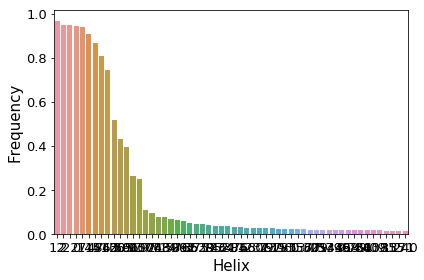

In [24]:
sns.barplot(y='frequency', x='helix', data=hfs, order=hfs['helix'])

plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13

plt.xlabel("Helix",fontsize=15)
plt.ylabel("Frequency",fontsize=15)

plt.tight_layout()